### Loading packages and Read data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from helpers import *

In [2]:
df = read_data()

读好数据啦！


In [3]:
df_resampled = undersample(df)

在Resampling之后有
0    27532
1     6883
Name: fraud_bool, dtype: int64


In [12]:
# One hot encoding
df = encode(df_resampled)

After encoding:
(34415, 65)


c:\ProgramData\Anaconda3\envs\datasci507\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


#### Train test split

In [7]:
X = df.drop('fraud_bool',axis=1)
y = df['fraud_bool']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(X_train.shape)

(24090, 64)


### Model

In [12]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
from sklearn.model_selection import GridSearchCV

#### KNN

In [14]:
from sklearn.neighbors import KNeighborsClassifier

在我的电脑上n_jobs不能用，你们想跑的快一点可以用回来n_jobs

verbose是print东西，verbose=10可以print的非常清楚

In [18]:
knn = KNeighborsClassifier()
param_grid = {'n_neighbors': np.arange(1, 50), 'weights': ['uniform', 'distance']}

# grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='roc_auc', verbose=1)
grid_search.fit(X_train.iloc[:3000], y_train.iloc[:3000])

best_knn_params = grid_search.best_params_
best_knn_estimator = grid_search.best_estimator_

print("Best Hyperparameters:")
print(grid_search.best_params_)

Fitting 5 folds for each of 98 candidates, totalling 490 fits
Best Hyperparameters:
{'n_neighbors': 48, 'weights': 'distance'}


In [19]:
best_knn_model = KNeighborsClassifier(**best_knn_params)
best_knn_model.fit(X_train,y_train)
y_knn_pred = best_knn_model.predict(X_test)
y_knn_pred_proba = best_knn_model.predict_proba(X_test)[:, 1]

Confusion Matrix:
[[8167   25]
 [2087   46]]

Classification Report:
              precision    recall  f1-score   support

           0       0.80      1.00      0.89      8192
           1       0.65      0.02      0.04      2133

    accuracy                           0.80     10325
   macro avg       0.72      0.51      0.46     10325
weighted avg       0.77      0.80      0.71     10325


Accuracy Score:
0.7954479418886199


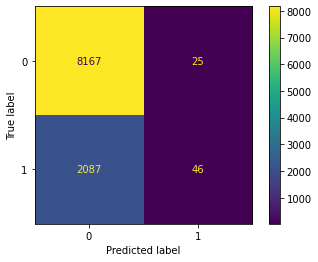

In [20]:
cm = confusion_matrix(y_test, y_knn_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = best_knn_model.classes_)
cm_display.plot();
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_knn_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_knn_pred))
print("\nAccuracy Score:")
print(accuracy_score(y_test, y_knn_pred))

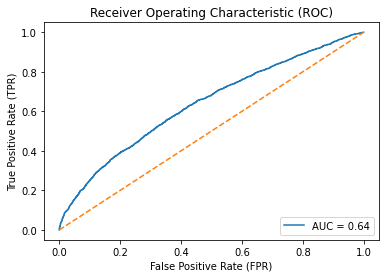

0.6384703988935039

In [21]:
auc_related(y_test, y_knn_pred_proba)

#### GBDT

In [22]:
from sklearn.ensemble import GradientBoostingClassifier

因为这里GridSearch用太久，我换成RandomizedSearchCV，结果不会差太多

如果你们电脑可以用n_jobs，那可以把n_iter换大一点，可以得到更好的结果

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

gbdt = GradientBoostingClassifier(random_state=42)
param_dist = {
    'n_estimators': range(100, 1000, 50),
    'learning_rate': np.logspace(-3, 0, 10),
    'max_depth': range(2, 10),
    'min_samples_split': range(2, 21),
    'min_samples_leaf': range(1, 21),
    'subsample': np.linspace(0.5, 1.0, 6),
    'max_features': ['sqrt', 'log2', None]
}

n_iter = 20

random_search = RandomizedSearchCV(
    gbdt, param_distributions=param_dist, n_iter=n_iter, cv=5,
    scoring='roc_auc', verbose=10, random_state=42
)

random_search.fit(X_train.iloc[:3000], y_train.iloc[:3000])

In [52]:
best_gbdt_params = random_search.best_params_
print("Best Hyperparameters:")
print(best_gbdt_params)

Best Hyperparameters:
{'subsample': 1.0, 'n_estimators': 100, 'min_samples_split': 14, 'min_samples_leaf': 8, 'max_features': 'log2', 'max_depth': 2, 'learning_rate': 0.046415888336127774}


In [53]:
best_gbdt_model = GradientBoostingClassifier(**best_gbdt_params)
best_gbdt_model.fit(X_train,y_train)
y_gbdt_pred = best_gbdt_model.predict(X_test)
y_gbdt_pred_proba = best_gbdt_model.predict_proba(X_test)[:, 1]

Confusion Matrix:
[[8065  127]
 [1537  596]]

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.98      0.91      8192
           1       0.82      0.28      0.42      2133

    accuracy                           0.84     10325
   macro avg       0.83      0.63      0.66     10325
weighted avg       0.84      0.84      0.81     10325


Accuracy Score:
0.8388377723970944


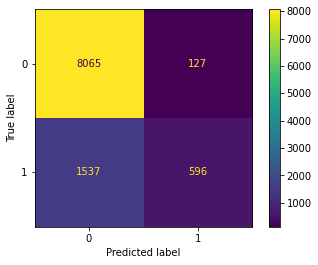

In [54]:
cm = confusion_matrix(y_test, y_gbdt_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = best_gbdt_model.classes_)
cm_display.plot();
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_gbdt_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_gbdt_pred))
print("\nAccuracy Score:")
print(accuracy_score(y_test, y_gbdt_pred))

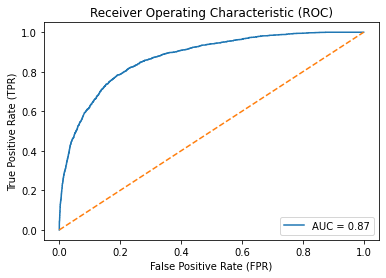

0.8729342761533785

In [55]:
auc_related(y_test,y_gbdt_pred_proba)

#### XGBoost

In [24]:
from xgboost import XGBClassifier

In [34]:
xgb = XGBClassifier(eval_metric='logloss', random_state=42)
param_dist = {
    'n_estimators': range(100, 1000, 50),
    'learning_rate': np.logspace(-3, 0, 10),
    'max_depth': range(3, 10),
    'min_child_weight': range(1, 6),
    'subsample': np.linspace(0.5, 1.0, 6),
    'colsample_bytree': np.linspace(0.5, 1.0, 6),
    'gamma': np.linspace(0, 0.5, 6),
    'reg_alpha': [0, 1e-1, 1, 10, 100],
    'reg_lambda': [0, 1e-1, 1, 10, 100],
    'scale_pos_weight': [1, 2, 3, 4]
}

# n_iter determines the number of random parameter combinations to try
n_iter = 20

random_search = RandomizedSearchCV(
    xgb, param_distributions=param_dist, n_iter=n_iter, cv=5,
    scoring='roc_auc', verbose=1, random_state=42
)

random_search.fit(X_train.iloc[:3000], y_train.iloc[:3000])

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='logloss',
                                           feature_types=None, gamma=None,
                                           gpu_id=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning...
                                        'learning_rate': array([0.001     , 0.00215443, 0.00464159, 0.01      , 0.02154435,
       0.04641589, 0.1       , 0.21544347, 0.46415888, 1.        ]),
                                        'max_depth': range(3, 10),
                                        'min_child_weight': range(1, 6),
                                        'n_estimators': range(100, 1000, 50),
                                        'reg_alpha': [0, 0.1, 1, 10, 100],
                                        'reg_lambda': [0, 0.1, 1, 10, 100],
                                        'scale_pos_weight': [1, 2, 3, 4],
                                        'subsample': array([0.5, 0.6, 0.7, 0.8, 0.9, 1. ])},
                   random_state=42, scoring='roc_auc', verbose=1)

In [39]:
best_xgb_params = random_search.best_params_
print("Best Hyperparameters:")
print(best_xgb_params)

Best Hyperparameters:
{'subsample': 0.7, 'scale_pos_weight': 1, 'reg_lambda': 0, 'reg_alpha': 10, 'n_estimators': 200, 'min_child_weight': 5, 'max_depth': 3, 'learning_rate': 0.21544346900318823, 'gamma': 0.0, 'colsample_bytree': 0.9}


In [36]:
best_xgb_model = XGBClassifier(**best_xgb_params)
# best_xgb_model = XGBClassifier()
best_xgb_model.fit(X_train,y_train)
y_xgb_pred = best_xgb_model.predict(X_test)
y_xgb_pred_proba = best_xgb_model.predict_proba(X_test)[:, 1]

Confusion Matrix:
[[7794  398]
 [1016 1117]]

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.95      0.92      8192
           1       0.74      0.52      0.61      2133

    accuracy                           0.86     10325
   macro avg       0.81      0.74      0.76     10325
weighted avg       0.85      0.86      0.85     10325


Accuracy Score:
0.8630508474576272


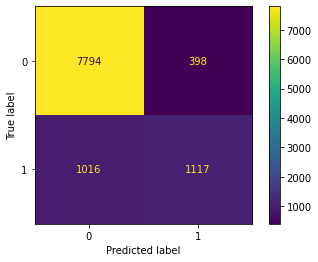

In [37]:
cm = confusion_matrix(y_test, y_xgb_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = best_xgb_model.classes_)
cm_display.plot();
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_xgb_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_xgb_pred))
print("\nAccuracy Score:")
print(accuracy_score(y_test, y_xgb_pred))

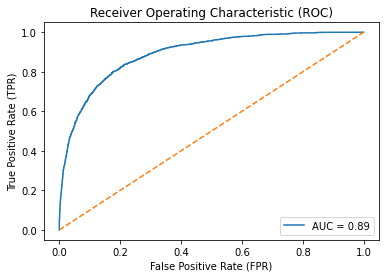

0.8912045907594204

In [40]:
auc_related(y_test, y_xgb_pred_proba)

#### MLP

In [36]:
from sklearn.neural_network import MLPClassifier

In [37]:
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 100)],
    'batch_size': [32, 64, 128],
    'max_iter': [100, 200, 300],
    'activation': ['relu', 'tanh'],
    'solver': ['adam'],
    'alpha': [0.01],
    'learning_rate': ['adaptive'],
    'learning_rate_init': [0.1]
}

mlp_model = MLPClassifier(random_state=42)
grid_search = GridSearchCV(estimator=mlp_model, param_grid=param_grid, cv=5, 
                           scoring='roc_auc', n_jobs=64)
grid_search.fit(X_train[:3000], y_train[:3000])

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iteration

GridSearchCV(cv=5, estimator=MLPClassifier(random_state=42), n_jobs=64,
             param_grid={'activation': ['relu', 'tanh'], 'alpha': [0.01],
                         'batch_size': [32, 64, 128],
                         'hidden_layer_sizes': [(50,), (100,), (50, 50),
                                                (100, 100)],
                         'learning_rate': ['adaptive'],
                         'learning_rate_init': [0.1],
                         'max_iter': [100, 200, 300], 'solver': ['adam']},
             scoring='roc_auc')

In [38]:
best_mlp_params = grid_search.best_params_
print("Best Hyperparameters:")
print(grid_search.best_params_)

Best Hyperparameters:
{'activation': 'relu', 'alpha': 0.01, 'batch_size': 32, 'hidden_layer_sizes': (50,), 'learning_rate': 'adaptive', 'learning_rate_init': 0.1, 'max_iter': 100, 'solver': 'adam'}


In [39]:
best_mlp_model = MLPClassifier(**best_mlp_params)
best_mlp_model.fit(X_train,y_train)
y_mlp_pred = best_mlp_model.predict(X_test)
y_mlp_pred_proba = best_mlp_model.predict_proba(X_test)[:, 1]

Confusion Matrix:
[[8192    0]
 [2133    0]]

Classification Report:
              precision    recall  f1-score   support

           0       0.79      1.00      0.88      8192
           1       0.00      0.00      0.00      2133

    accuracy                           0.79     10325
   macro avg       0.40      0.50      0.44     10325
weighted avg       0.63      0.79      0.70     10325


Accuracy Score:
0.7934140435835351


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

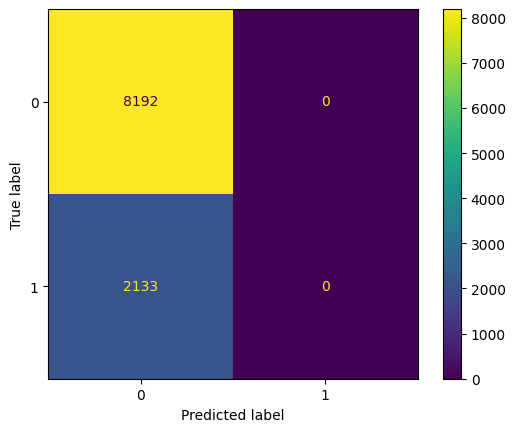

In [40]:
cm = confusion_matrix(y_test, y_mlp_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = best_mlp_model.classes_)
cm_display.plot();
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_mlp_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_mlp_pred))
print("\nAccuracy Score:")
print(accuracy_score(y_test, y_mlp_pred))

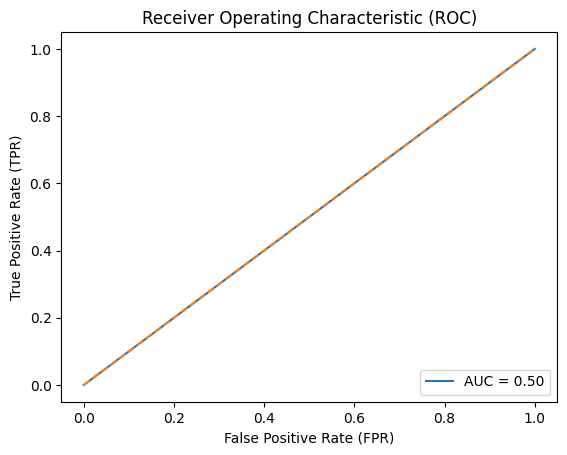

0.5

In [41]:
auc_related(y_test, y_mlp_pred)